For Exploratory Data Analysis (EDA), you can do the followings:

1- Plot the audio wave-form for couple of subjects
2- How many age groups do we have in the dataset? How many unique type of disease do exist?
3- How many types of channels do we have? Which one is common among all measurements?
Obtain the percentage of each channel across all recordings.
4- Obtain the correlation among different channels for a few subjects from different age groups
5- Explore Short-Time-Frequency-Transform (STFT) and Mel Spectrogram: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53. Apply these two transformations for some subjects



Descriptive Statistics:
Calculate mean, median, and standard deviation of age and recording duration.

Visualization:
Create histograms and box plots for age and recording duration.

Cardiac Murmurs Analysis:
Distribution across age groups and auscultation locations.

Annotations Analysis:
Explore timing, shape, pitch, grading, quality, and location of murmurs.

Segmentation Annotations:
Analyze consensus and mismatches between algorithms and human annotations.

Correlation Analysis:
Study correlations between different annotation types and age groups.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install pydub
!pip3 install wfdb

from pathlib import Path
from glob import glob
from pydub import AudioSegment
from tqdm import tqdm
from typing import Literal
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
import librosa
import os, sys
import re
import itertools
import wfdb # reading hea files


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.2 MB/s eta 0:00:00


# Data Loading

In [3]:
PATH = '/content/drive/MyDrive/Drexel/DL_Heart_Disease/training_data.csv'
DATASET_PATH = '/content/drive/MyDrive/Drexel/DL_Heart_Disease/dataset/training_data'

original_data = pd.read_csv(PATH)

# Data Wrangling

In [8]:
# Feel free to add your own lines of code to handle further data manipulation (wrangling)
# before feeding it to future ML models

def data_wrangling(df : pd.DataFrame):

    data = df.copy(deep=True)
    data['Age'].fillna('Young Adult', inplace = True) # Labeling 'nan' values in age column

    # New columns
    data['Recording Channels'] = data['Recording locations:'].str.split('+')
    data['Murmur Channels'] = data['Murmur locations'].str.split('+')

    # Mapping of string values to integer values
    outcome_mapping = {'Normal': 0, 'Abnormal': 1}
    data['Outcome'] = data['Outcome'].replace(outcome_mapping)


    # Further mapping if required later
    # smt_mapping = {'Early-systolic': 0, 'Mid-systolic': 1, 'Late-systolic': 2, 'Holosystolic': 3}
    # sms_mapping = {'Crescendo': 0, 'Decrescendo': 1, 'Diamond': 2, 'Plateau': 3}
    # smg_mapping = {'I/VI': 0, 'II/VI': 1, 'III/VI': 2}
    # smp_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    # smq_mapping = {'Musical': 0, 'Blowing': 1, 'Harsh': 2}

    # dmt_mapping = {'Early-diastolic': 0, 'Holodiastolic': 1, 'Mid-diastolic': 2}
    # dms_mapping = {'Decrescendo': 0, 'Plateau': 1}
    # dmg_mapping = {'I/IV': 0, 'II/IV': 1, 'III/IV': 2}
    # dmp_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    # dmq_mapping = {'Blowing': 0, 'Harsh': 1}


    # Add new lines as needed for future work
    '''

    '''
    return data


def label_encoding(df: pd.DataFrame, cols: list):
    data = df.copy(deep=True)
    data = data[cols]
    for col in cols:
        data[col] = LabelEncoder().fit_transform(data[col])
        ## Figure out how to extract dict key-val matching pair
        # label_mapping = {encoded: label for encoded, label in enumerate(label_encoder.classes_)}

    # print(label_mapping)
    return data


def one_hot_encoding(df : pd.DataFrame, cols: list):
    data = df.copy(deep=True)
    data = data[cols]
    df_encoded = pd.get_dummies(data, dtype=int)

    return df_encoded

In [9]:
my_df = data_wrangling(original_data)

my_df.head()

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID,Recording Channels,Murmur Channels
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,CC2015,NaN,"[AV, PV, TV, MV]",NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,NaN,NaN,NaN,NaN,NaN,1,CC2015,NaN,"[AV, PV, TV, MV]","[AV, MV, PV, TV]"
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,CC2015,NaN,"[AV, PV, TV, MV]",NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,NaN,NaN,NaN,NaN,NaN,1,CC2015,NaN,"[AV, PV, TV, MV]",[TV]
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,NaN,NaN,NaN,NaN,NaN,1,CC2015,NaN,"[AV, PV, TV, MV]","[AV, MV, PV, TV]"


# Functions

In [10]:
def create_histogram(df : pd.DataFrame, col : str, title='', x_label=''):
    if type(df[col][0]) != list:
        obj = Counter(df[col]) # Create Counter object
    else:
        flattened = [channel for sublist in df[col] for channel in sublist]
        obj = Counter(flattened)

    # Convert the Counter object into a DataFrame
    counter_df = pd.DataFrame.from_dict(obj, orient='index', columns=['Count'])
    # Use Seaborn to create histogram
    plt.figure(figsize=(10, 6), dpi=80)
    sns.barplot(x=counter_df.index, y=counter_df['Count'])

    # Add labels on top of each bar
    for i, v in enumerate(obj.values()):
        plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

    plt.title(title)
    plt.xlabel(x_label)
    plt.xticks(rotation=45)
    plt.show()


def create_histogram_corr(df : pd.DataFrame, title = '', x = '', hue = '', x_label = ''):
    plt.figure(figsize=(10,6), dpi=80)
    sns.countplot(data = df, x = x, hue = hue, palette = 'Set1')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Count')
    plt.legend(title = hue)
    plt.xticks(rotation=45)
    plt.show()


def create_histogram_W(data : list, title='', x_label=''):
  plt.figure(figsize=(10, 6), dpi=80)
  plt.hist(data,edgecolor="black")
  plt.title(title)
  plt.xlabel(x_label)
  plt.show()

def channels_iterator(folder : Path, channel : Literal["AV","TV","MV","PV","Phc"], ext : Literal[".txt",".wav"]):
    return iter(glob( str(folder / f"*{channel}*{ext}") ))


def get_audio_info(audio_file_path : str):
    try:
        audio = AudioSegment.from_file(audio_file_path)
        duration_in_seconds = len(audio) / 1000.0  # Convert to seconds
        sample_rate = audio.frame_rate
        return duration_in_seconds, sample_rate

    except Exception as e:
        print(f"Error: {e}")
        raise e


def get_hea_info(hea_file):
    record = wfdb.rdheader(hea_file[:-4])
    duration = record.sig_len / record.fs  # Calculate duration in seconds
    sample_rate = record.fs
    return duration, sample_rate


# Helper function for outcome distribution
# Visualize the proportion of borrowers
def show_outcome_distrib(df: pd.DataFrame):
    count = ""
    if isinstance(df, pd.DataFrame):
        count = df['Outcome'].value_counts()
    else:
        count = df.value_counts()

    count.plot(kind = 'pie', explode = [0, 0.1], figsize = (6,6), autopct = '%1.1f%%', shadow = True)

    plt.ylabel("OUtcome: Normal vs Abnormal")
    plt.legend(['Normal', 'Abnormal'])
    plt.show()

In [11]:
def draw_waves(wave):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(waves[wave]['signal'], sr=waves[wave]['sr'])
  plt.title(wave + ' Wave')
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

In [12]:
def draw_spectrum(wave):
  fft = np.fft.fft(waves[wave]['signal'])
  magnitude = np.abs(fft)
  frequency = np.linspace(0,waves[wave]['sr'],len(magnitude))

  left_frequency = frequency[:int(len(frequency)/2)]
  left_magnitude = magnitude[:int(len(frequency)/2)]

  plt.plot(left_frequency,left_magnitude)
  plt.title(wave + ' magnitude spectrum')
  plt.xlabel('frequency')
  plt.ylabel('magnitude')
  plt.show()

In [13]:
def draw_Spectrogram(wave):
  STFT = librosa.stft(waves[wave]['signal'])
  amplitude = librosa.amplitude_to_db(abs(STFT), ref=np.max)

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(amplitude, sr=waves[wave]['sr'], x_axis='time', y_axis='log')
  plt.colorbar(format='%+2.0f dB')
  plt.title(wave + ' Spectrogram')
  plt.tight_layout()
  plt.show()

# 1- Plot the audio wave-form for couple of subjects

In [14]:
waves = {}
for i in ["AV","MV","PV","TV"]:
  path = DATASET_PATH + "/2530_" + i + ".wav"
  waves[i] = {}
  waves[i]['signal'], waves[i]['sr'] = librosa.load(path)

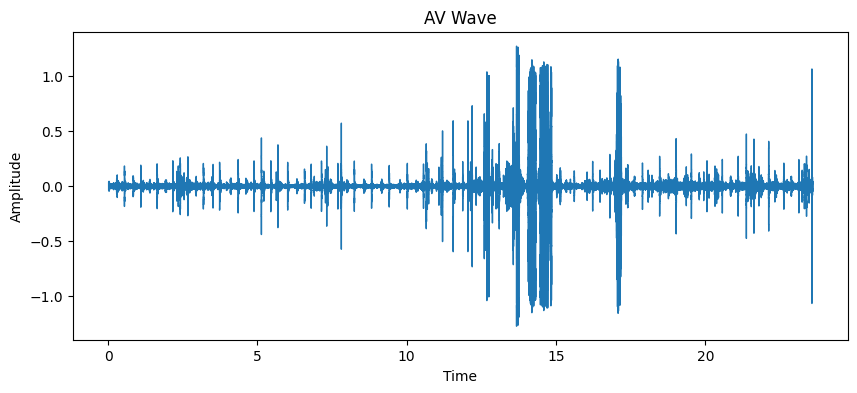

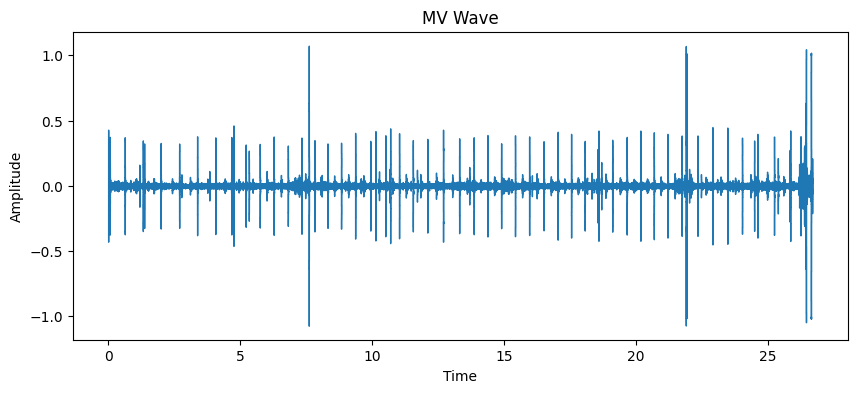

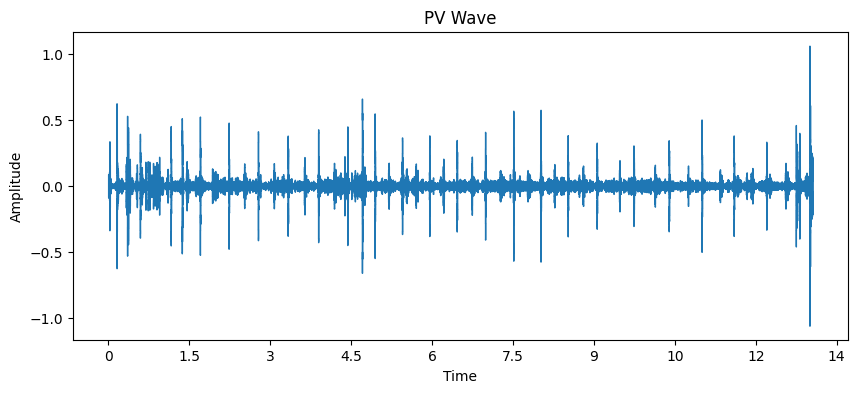

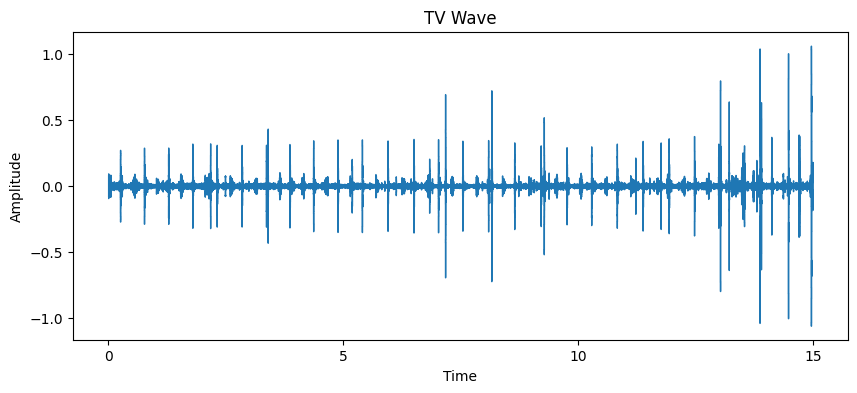

In [15]:
for wave in waves:
  draw_waves(wave)

# 2- How many age groups do we have in the dataset?

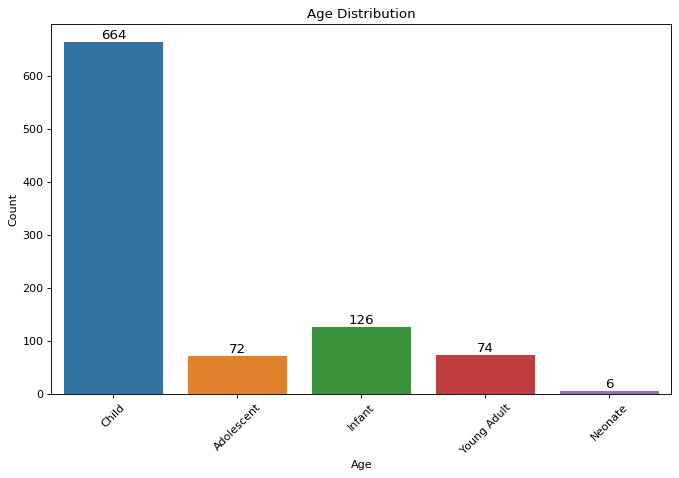

In [16]:
# Uncomment below to show graph

create_histogram(my_df, "Age", "Age Distribution", "Age")
# create_histogram(list(original_data["Age"]), "Age distribution", "Age")

# 3- How many types of channels do we have? Which one is common among all measurements? Obtain the percentage of each channel across all recordings.

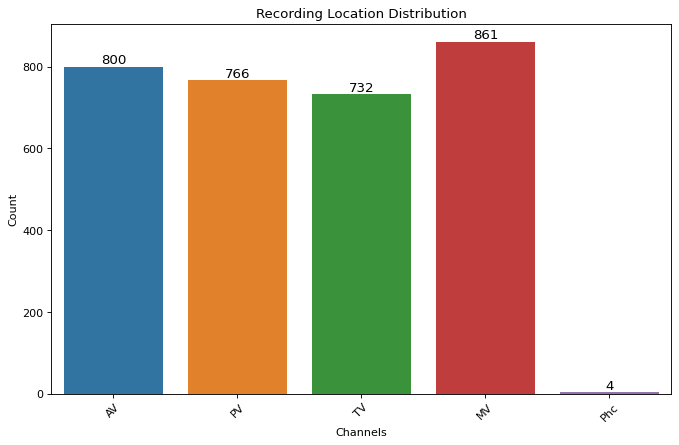

In [17]:
# NOTE : this is only showing the graph (histogram) | please add other things

# Uncomment below to show graph

create_histogram(my_df, "Recording Channels", "Recording Location Distribution", "Channels")

# all_channels_in_list = list(itertools.chain(*[channels.split("+") for channels in list(data_original["Recording locations:"])]))
# create_histogram(all_channels_in_list, "Channel distribution", "Channel")

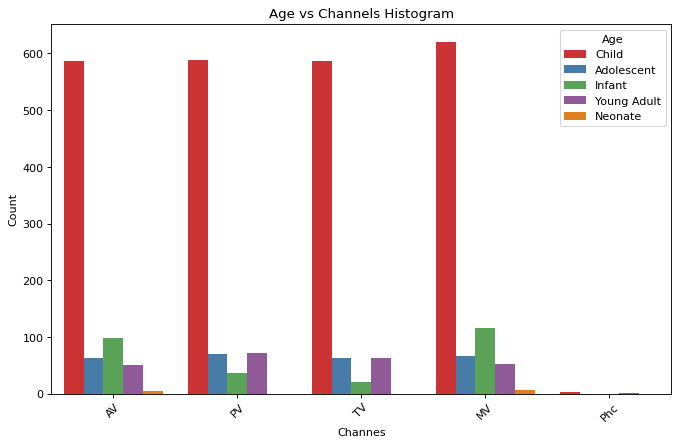

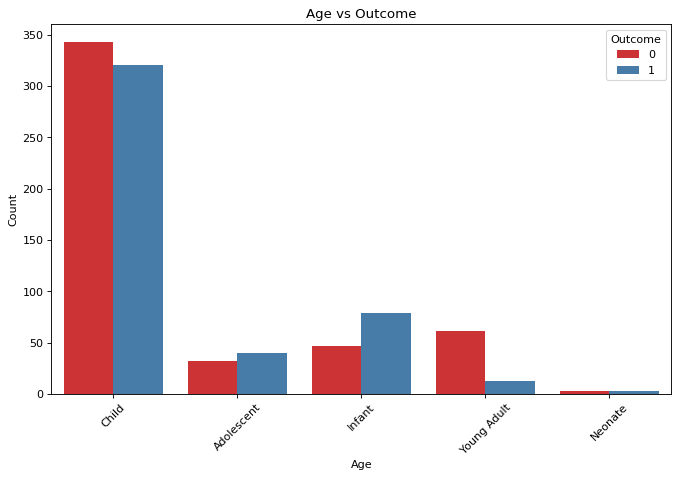

In [18]:
temp = my_df.explode('Recording Channels')[['Age', 'Recording Channels']]
create_histogram_corr(temp, 'Age vs Channels Histogram', 'Recording Channels', 'Age', x_label = 'Channes')


create_histogram_corr(my_df[['Age','Outcome']], title='Age vs Outcome', x='Age', hue='Outcome', x_label='Age')

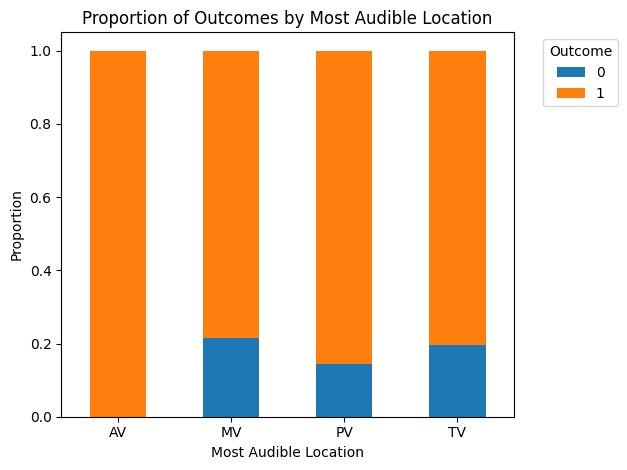

In [19]:
grouped = my_df.groupby(by=['Most audible location', 'Outcome']).size().unstack(fill_value=0)
grouped_prop = grouped.div(grouped.sum(axis=1), axis=0)
grouped_prop.plot(kind='bar', stacked=True)
plt.title('Proportion of Outcomes by Most Audible Location')
plt.xlabel('Most Audible Location')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

# 4- Obtain the correlation among different channels for a few subjects from different age groups

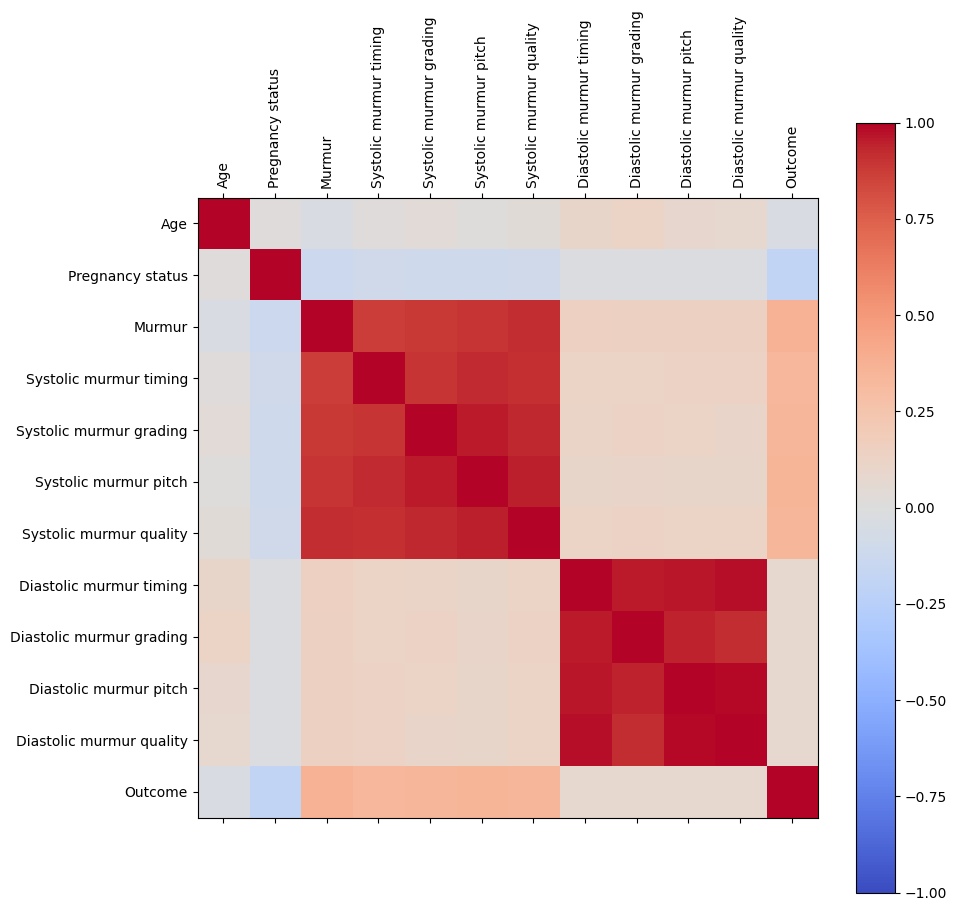

In [20]:
def show_data_corr_heat_map(data_original : pd.DataFrame):
  data = data_original.copy(deep=True)

  # As for now , height and weight is not included for the reason of age group & sex
  mappings = {
      "Age" : {'Adolescent' : (18+12)/2, np.nan : 6.1, 'Neonate' : (27+0)/(2*365),
              'Child' : (11+1)/2, 'Infant' :(365+27)/(2*365)}, # I'm doing this mean age of each group
      "Pregnancy status" : {False : -1, True : 1},
      'Murmur': {"Present": 1, "Absent": -1, "Unknown": 0},
      'Systolic murmur timing': {"Early-systolic": 1, "Holosystolic": 4,
                                "Late-systolic": 3, "Mid-systolic": 2, np.nan: -1},
      'Systolic murmur grading': {"I/VI": 1, "II/VI": 2, "III/VI": 3, np.nan: -1},
      'Systolic murmur pitch': {"Low": 1, "Medium": 2, "High": 3, np.nan: -1},
      'Systolic murmur quality': {"Blowing": 1, "Harsh": 2, "Musical": 3, np.nan: -1},
      'Diastolic murmur timing': {"Early-diastolic": 1, "Holodiastolic": 3,
                                  "Mid-diastolic": 2, np.nan: -1},
      'Diastolic murmur grading': {"I/IV": 1, "II/IV": 2, "III/IV": 3, np.nan: -1},
      'Diastolic murmur pitch': {"Low": 1, "Medium": 2, "High": 3, np.nan: -1},
      'Diastolic murmur quality': {"Blowing": 1, "Harsh": 2, np.nan: -1},
      "Outcome": {"Normal": -1, "Abnormal": 1}
  }

  all_fields = list(mappings.keys())

  for column, mapping in mappings.items():
      data[column] = data[column].map(mapping)

  correlation_matrix = data[all_fields].corr()

  fig, ax = plt.subplots(figsize=(10, 10))
  cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
  ax.set_xticks(range(len(all_fields)))
  ax.set_yticks(range(len(all_fields)))
  ax.set_xticklabels(all_fields, rotation=90)
  ax.set_yticklabels(all_fields)
  fig.colorbar(cax)
  plt.show()

# Uncomment
show_data_corr_heat_map(original_data)

# 5- Explore Short-Time-Frequency-Transform (STFT) and Mel Spectrogram: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53. Apply these two transformations for some subjects

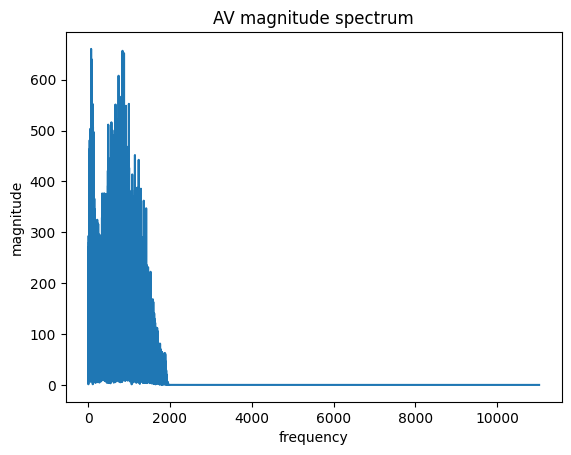

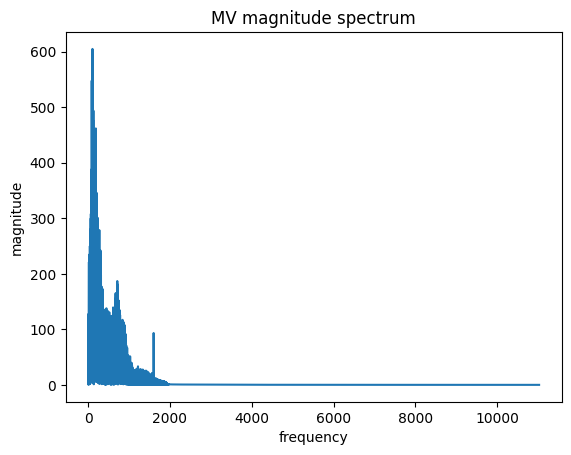

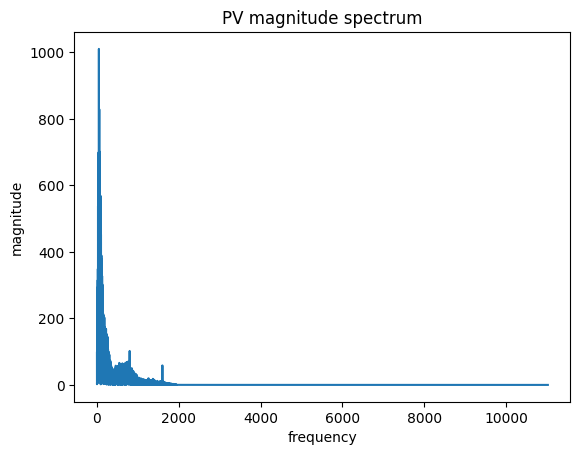

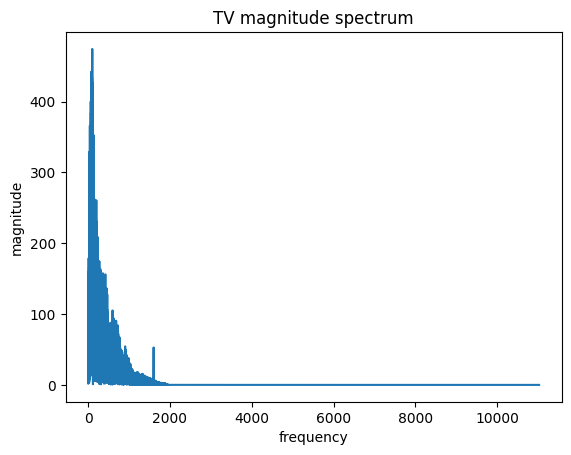

In [21]:
for wave in waves:
  draw_spectrum(wave)

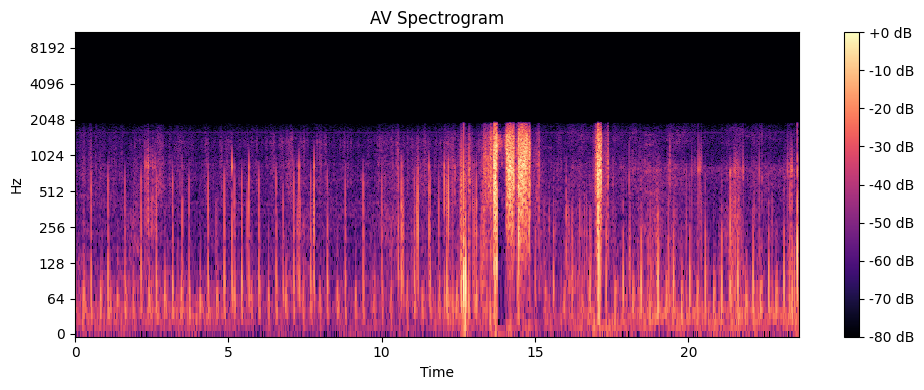

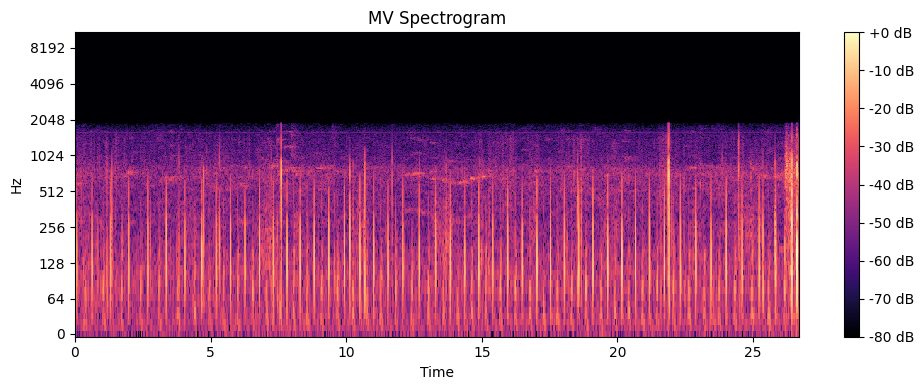

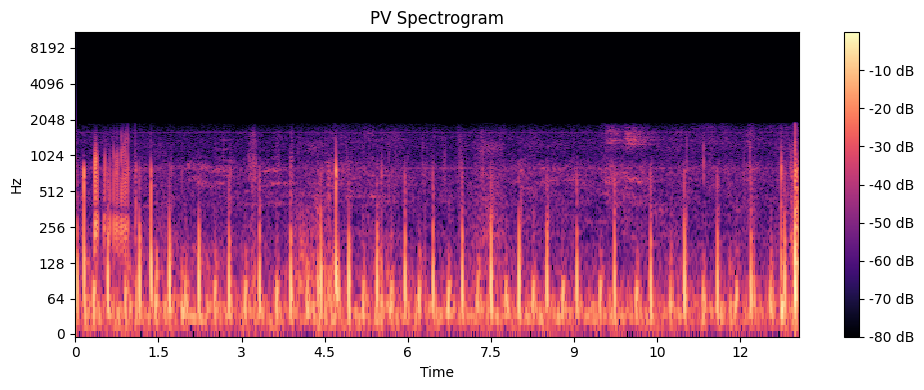

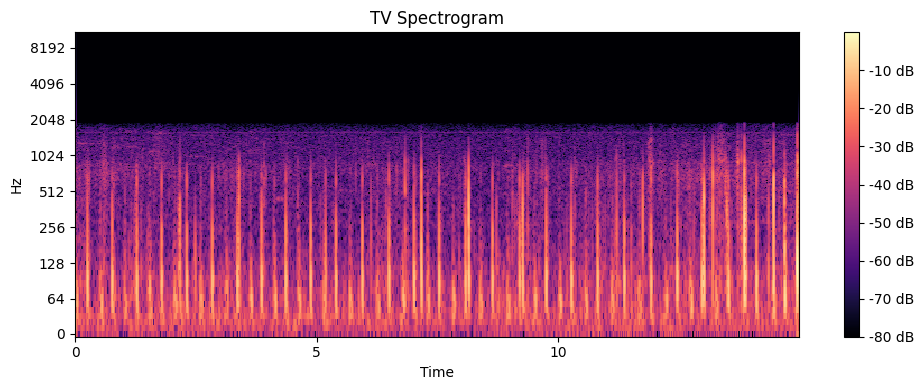

In [22]:
for wave in waves:
  draw_Spectrogram(wave)

# 6 - Time duration of each channel

4it [00:01,  2.56it/s]


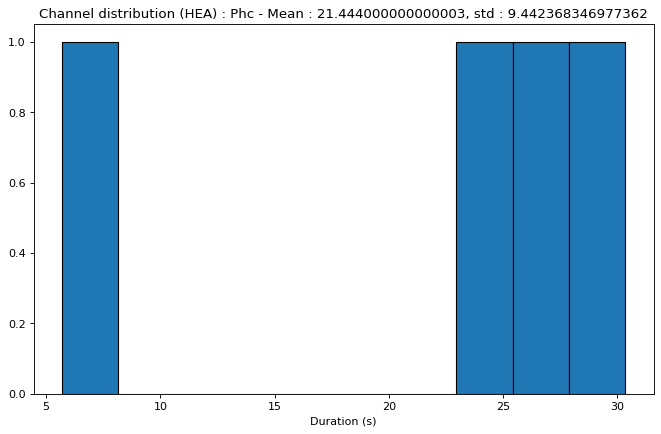

800it [03:53,  3.42it/s] 


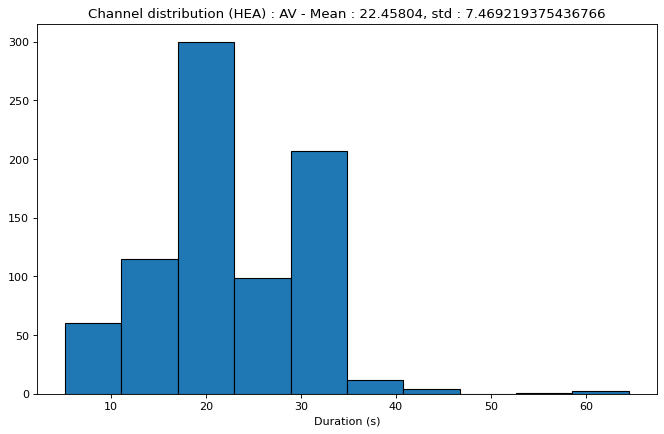

766it [00:12, 60.07it/s] 


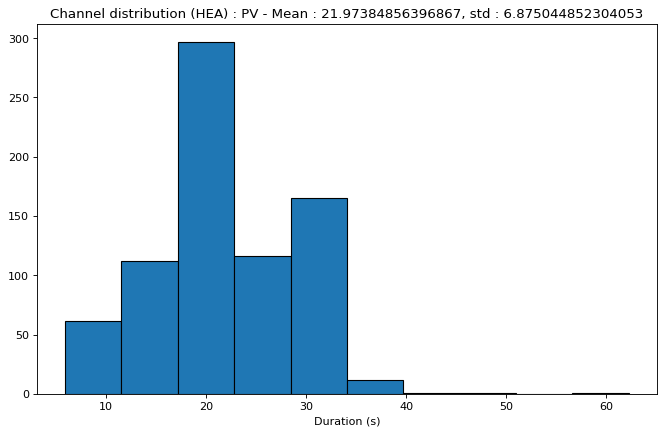

861it [00:01, 467.37it/s]


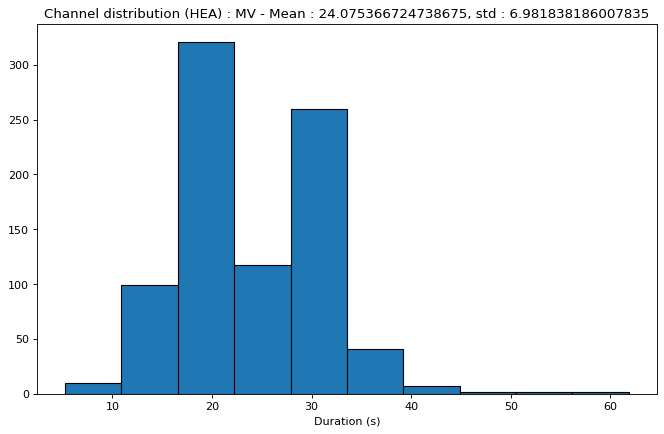

732it [00:01, 468.36it/s]


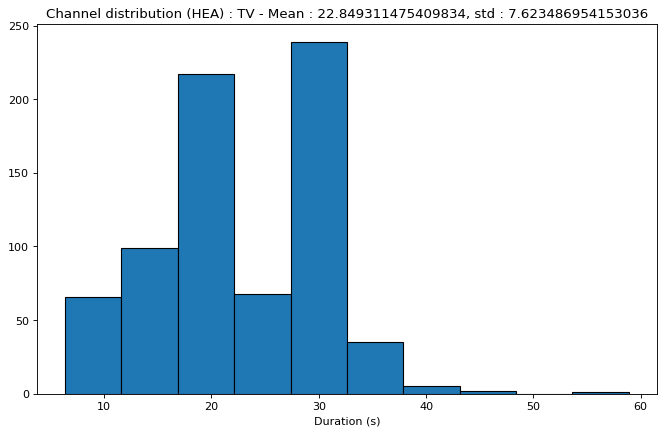

ValueError: ignored

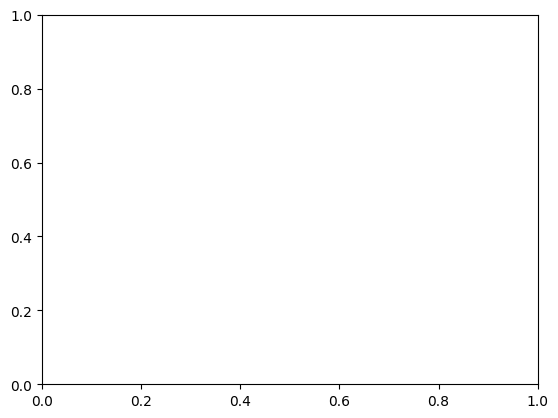

In [23]:

def display_time_duration_graph(training_data_path : str):
  box_plot_durations = []
  my_channels = ['Phc', 'AV', 'PV', 'MV', 'TV']

  TRAINING_DATA_FOLDER : Path = Path(training_data_path)
  for channel in my_channels:

      durations = []
      # second is hea file check -> header detail
      for file in tqdm(channels_iterator(TRAINING_DATA_FOLDER, channel, ".hea")):
          secs, samp_rate = get_hea_info(file)
          durations.append(secs)

      mean, std = np.mean(durations), np.std(durations)

      create_histogram_W(
          durations,
          f"Channel distribution (HEA) : {channel} - Mean : {mean}, std : {std}",
          f"Duration (s)",
      )

  plt.boxplot(box_plot_durations, labels = my_channels)
  plt.title('Box Plot for each channel duration')
  plt.xlabel('Channels')
  plt.ylabel('Time (s)')

  plt.show()

# Uncommment

display_time_duration_graph(DATASET_PATH)

# Model Pipeline

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
# model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

# Model Evaluation

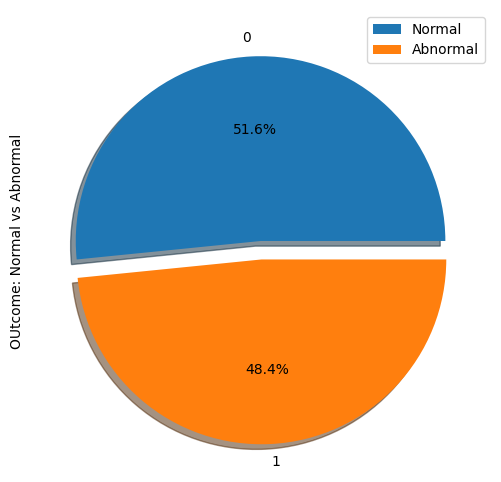

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


model_df = data_wrangling(original_data)


X = one_hot_encoding(model_df, ['Sex', 'Murmur', 'Age', 'Systolic murmur quality', 'Systolic murmur pitch',
                                'Systolic murmur grading', 'Systolic murmur shape', 'Systolic murmur timing', 'Most audible location'
                               ])

y = model_df['Outcome']

# To verify if there's potential need for balancing the dataset
show_outcome_distrib(y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=111)


model_list = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []


for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))


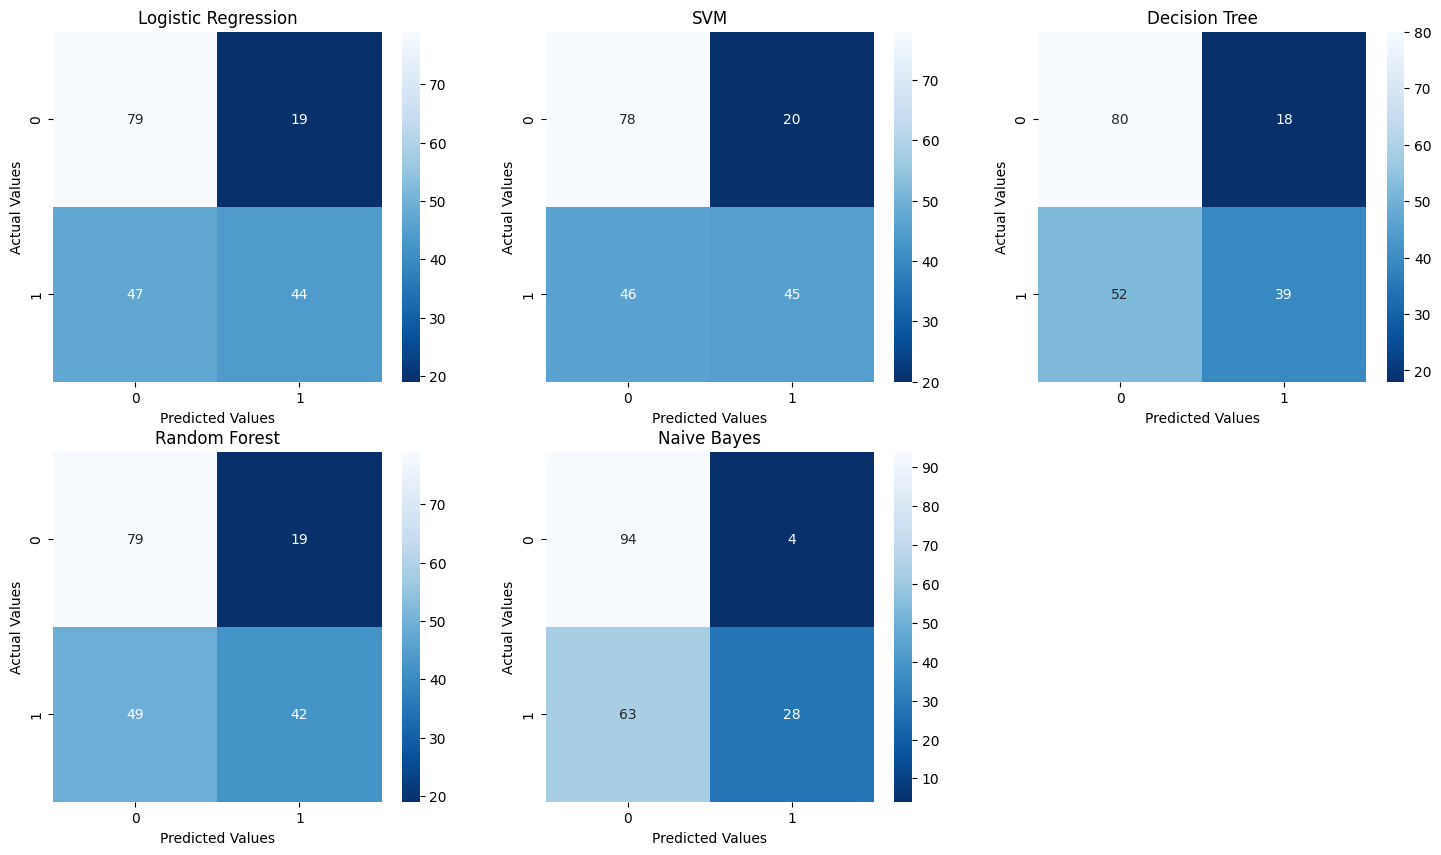

In [32]:
## plot confusion matrix
fig = plt.figure(figsize = (18, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap = 'Blues_r')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')

In [33]:
## Accuracy and AUC
result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_df

,Model,Accuracy,AUC
0,Logistic Regression,0.650794,0.64
1,SVM,0.650794,0.65
2,Decision Tree,0.629630,0.62
3,Random Forest,0.640212,0.63
4,Naive Bayes,0.645503,0.63


# Potential To Do List
- Feature Selection/Extraction (PCA)
- Consider New Synthetic Features (time duration by channel? by record?)

## Next Step for DL:
- Spectrogram (image) --> CNN? LSTM?


In [ ]:
'''


'''

In [ ]:
!pip show torch

Name: torch
Version: 2.1.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision


In [ ]:
import torchaudio
import numpy as np
from matplotlib import pyplot as plt
import librosa

In [ ]:

# waveform, sample_rate = torchaudio.load("sample.wav")

waveform, sample_rate = torchaudio.load("/content/drive/MyDrive/Drexel/DL_Heart_Disease/sample.wav")


In [ ]:
waveform.shape, sample_rate

(torch.Size([1, 106624]), 4000)

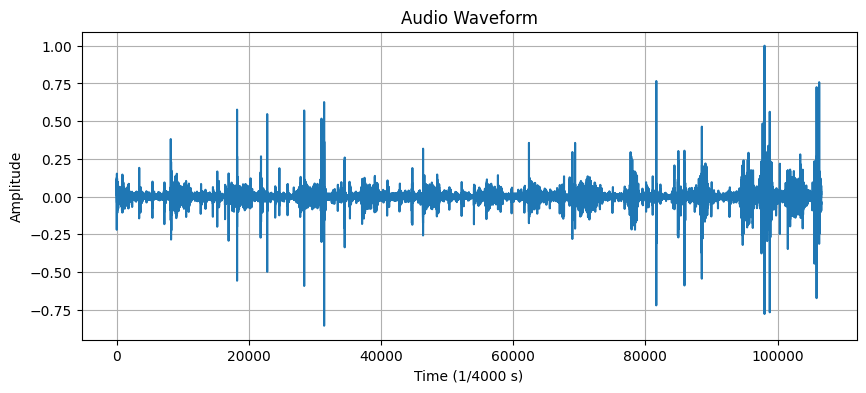

In [ ]:
waveform_np = waveform.numpy()

plt.figure(figsize=(10, 4))
plt.plot(waveform_np[0])
plt.xlabel(f'Time (1/{sample_rate} s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.grid()
plt.show()

In [ ]:
fft = np.fft.fft(waveform_np[0])

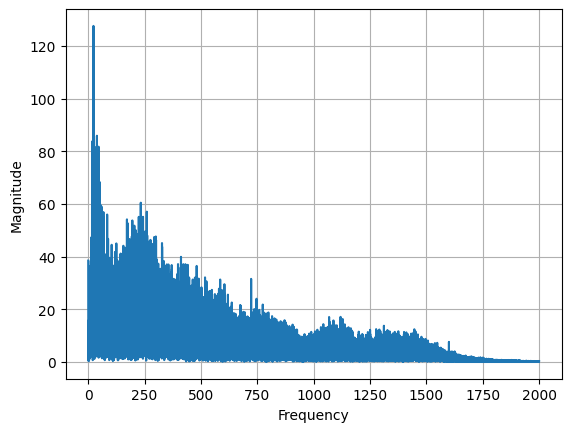

In [ ]:
mag = np.abs(fft) # Like strength of the frequency

freq = np.linspace(0, sample_rate, len(mag))  # Max Hz <= sample rate


plt.plot(left_freq := freq[:len(freq)//2], left_mag := mag[:len(freq)//2])
plt.xlabel(f'Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

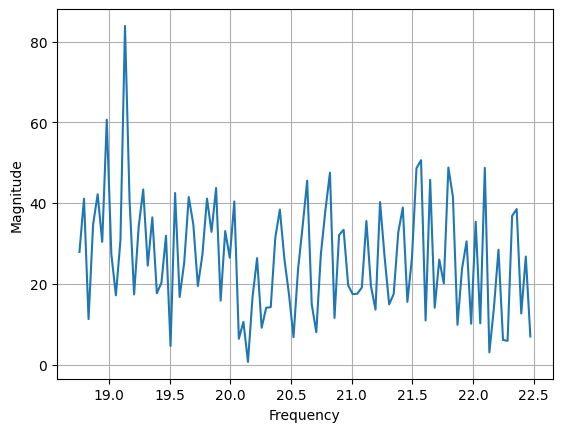

In [ ]:
left = 500
right = left + 100

plt.plot(left_freq[left:right] , left_mag[left:right])
plt.xlabel(f'Frequency')
plt.ylabel('Magnitude')
plt.grid()
plt.show()